# CutMix data augmentation for image classification

**Author:** [Sayan Nath](https://twitter.com/sayannath2350)<br>
**Date created:** 2021/06/08<br>
**Last modified:** 2023/11/14<br>
**Description:** Data augmentation with CutMix for image classification on CIFAR-10.

## Introduction

_CutMix_ is a data augmentation technique that addresses the issue of information loss
and inefficiency present in regional dropout strategies.
Instead of removing pixels and filling them with black or grey pixels or Gaussian noise,
you replace the removed regions with a patch from another image,
while the ground truth labels are mixed proportionally to the number of pixels of combined images.
CutMix was proposed in
[CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/abs/1905.04899)
(Yun et al., 2019)

It's implemented via the following formulas:

<img src="https://i.imgur.com/cGvd13V.png" width="200"/>

where `M` is the binary mask which indicates the cutout and the fill-in
regions from the two randomly drawn images and `λ` (in `[0, 1]`) is drawn from a
[`Beta(α, α)` distribution](https://en.wikipedia.org/wiki/Beta_distribution)

The coordinates of bounding boxes are:

<img src="https://i.imgur.com/eNisep4.png" width="150"/>

which indicates the cutout and fill-in regions in case of the images.
The bounding box sampling is represented by:

<img src="https://i.imgur.com/Snph9aj.png" width="200"/>

where `rx, ry` are randomly drawn from a uniform distribution with upper bound.

## Setup

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt

from keras import layers

# TF imports related to tf.data preprocessing
from tensorflow import clip_by_value
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random

keras.utils.set_random_seed(42)

## Load the CIFAR-10 dataset

In this example, we will use the
[CIFAR-10 image classification dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


## Define hyperparameters

In [3]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

## Define the image preprocessing function

In [9]:
import tensorflow as tf

def preprocess_image(image, label):
    image = tf_image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf_image.convert_image_dtype(image, "float32") / 255.0
    label = tf.cast(label, dtype="float32")
    return image, label


## Convert the data into TensorFlow `Dataset` objects

In [11]:
train_ds_one = (
    tf_data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf_data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf_data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Define the CutMix data augmentation function

The CutMix function takes two `image` and `label` pairs to perform the augmentation.
It samples `λ(l)` from the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)
and returns a bounding box from `get_box` function. We then crop the second image (`image2`)
and pad this image in the final padded image at the same location.

In [17]:
import tensorflow as tf
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def get_box(lambda_value):
    cut_rat = tf.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, "int32")

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, "int32")

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE)  # rx
    cut_x = tf.cast(cut_x, "int32")
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE)  # ry
    cut_y = tf.cast(cut_y, "int32")

    boundaryx1 = clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf_image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf_image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf_image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf_image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, "float32")

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


**Note**: we are combining two images to create a single one.

## Visualize the new dataset after applying the CutMix augmentation

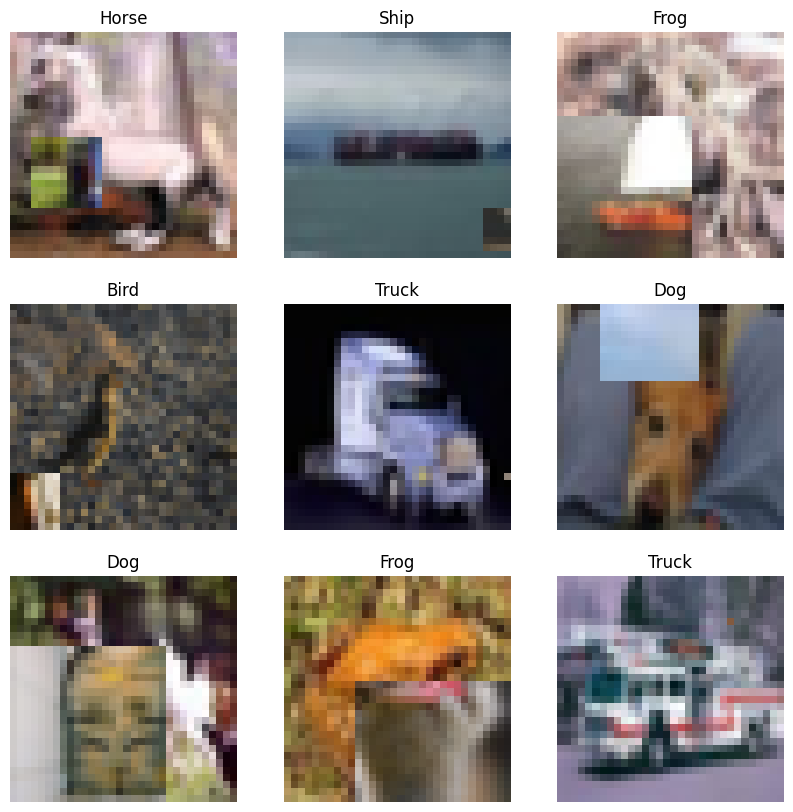

In [19]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

## Define a ResNet-20 model

In [20]:

def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.L2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = layers.add([x, y])
            x = layers.Activation("relu")(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)

    # Instantiate model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def training_model():
    return resnet_v20((32, 32, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights.weights.h5")

## Train the model with the dataset augmented by CutMix

In [ ]:
model = training_model()
model.load_weights("initial_weights.weights.h5")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_cmu, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 61s 28ms/step - loss: 1.9352 - accuracy: 0.4016 - val_loss: 1.5422 - val_accuracy: 0.5108
Epoch 2/15
1563/1563 [==============================] - 41s 26ms/step - loss: 1.6920 - accuracy: 0.5191 - val_loss: 1.2146 - val_accuracy: 0.6172
Epoch 3/15
 241/1563 [===>..........................] - ETA: 33s - loss: 1.6050 - accuracy: 0.5635

## Train the model using the original non-augmented dataset

In [ ]:
model = training_model()
model.load_weights("initial_weights.weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_simple, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

## Notes

In this example, we trained our model for 15 epochs.
In our experiment, the model with CutMix achieves a better accuracy on the CIFAR-10 dataset
(77.34% in our experiment) compared to the model that doesn't use the augmentation (66.90%).
You may notice it takes less time to train the model with the CutMix augmentation.

You can experiment further with the CutMix technique by following the
[original paper](https://arxiv.org/abs/1905.04899).